Based on https://www.nature.com/articles/s41598-018-35682-z

In [1]:
!pip install -U scikit-learn
!pip install -U pandas

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.0.3)


### Load Data

In [2]:
import pandas as pd

url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-35682-z/MediaObjects/41598_2018_35682_MOESM2_ESM.csv"
data = pd.read_csv(url)
data.describe(include="all")

,Tumor,Project,SNP,INDEL,SNP_R,INDEL_R,t_mutation,t_mutation_R,SNP_R/SNP,INDEL_R/INDEL,tm_R/tm,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Silent,Splice_Site,3'UTR,3'Flank,5'UTR,5'Flank,Intron,MSI_status,MSI_Class
count,1432,1432,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000,1432,1432.000000
unique,1432,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,TCGA-EY-A549,UCEC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSS,NaN
freq,1,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,932,NaN
mean,NaN,NaN,19.346220,1.960276,0.010018,0.005590,21.306496,0.015608,0.000518,0.003999,0.000824,0.783517,0.326652,0.030710,0.047944,10.256265,0.908657,3.803227,0.233837,2.428619,0.235740,0.442179,0.142073,1.070092,NaN,0.215782
std,NaN,NaN,60.727592,4.273285,0.026562,0.016679,62.250332,0.036943,0.001932,0.024374,0.002672,1.674924,1.091665,0.053966,0.434907,30.992942,3.213414,11.039378,0.733350,8.982673,0.896593,1.284118,0.484395,3.393037,NaN,0.411508
min,NaN,NaN,0.020000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,1.995000,0.113636,0.000000,0.000000,2.180000,0.000000,0.000000,0.000000,0.000000,0.022727,0.022727,0.000000,0.000000,1.140000,0.080000,0.420000,0.020000,0.100000,0.000000,0.040000,0.000000,0.068182,NaN,0.000000
50%,NaN,NaN,3.318182,0.200000,0.000000,0.000000,3.564091,0.000000,0.000000,0.000000,0.000000,0.068182,0.045455,0.020000,0.000000,1.886364,0.140000,0.727273,0.045455,0.220000,0.022727,0.080000,0.022727,0.136364,NaN,0.000000
75%,NaN,NaN,8.596591,1.022727,0.000000,0.000000,11.966364,0.020000,0.000000,0.000000,0.000256,0.227273,0.204545,0.041364,0.022727,4.727273,0.363636,1.886364,0.120000,0.763182,0.068182,0.250000,0.068182,0.520000,NaN,0.000000


### Explore

Table 1 Composition of training and testing data sets according to tumor types.

| Project	| Training | Testing |
|---|---|---|
|COAD|278|99|
|READ|92|39|
|STAD|334|103|
|UCEC|370|117|
|Total|1074|358|

Table 2 Composition of training and testing data sets according to MSI-PCR determined MSI status.

|MSI status|Training|Testing|
|---|---|---|
|MSS*|705|227|
|MSI-L*|138|53|
|MSI-H|231|78|
|Total|1074|358|

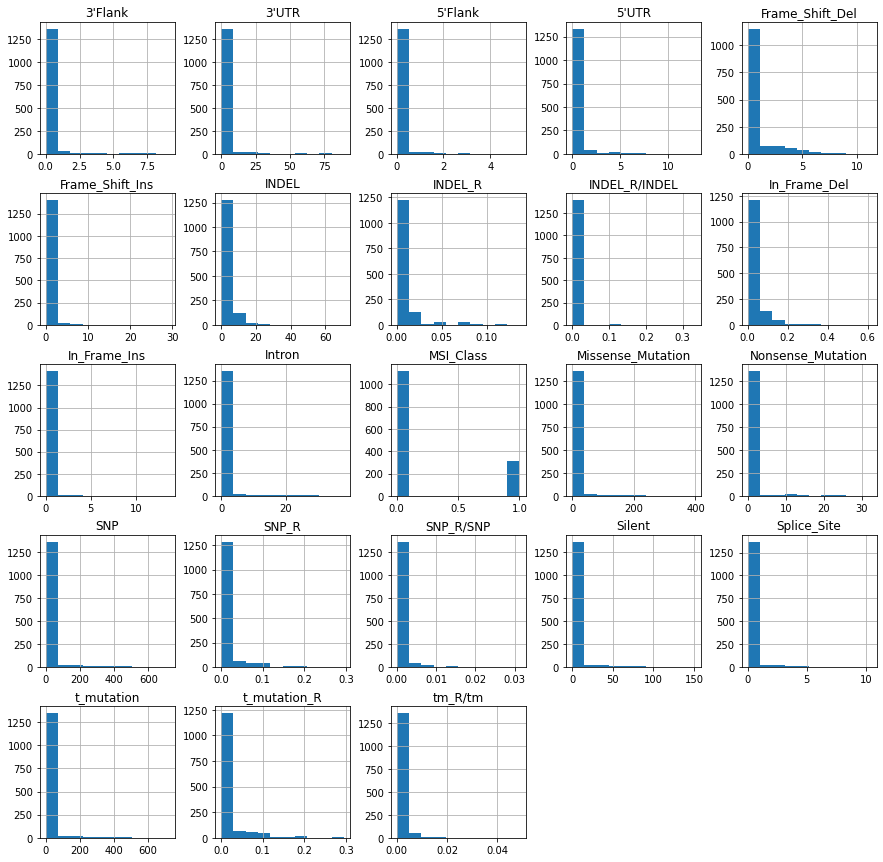

In [3]:
data.hist(figsize=(15,15));

#### MSI class
0: MSS / MSI-L  
1: MSI-H
#### Tumor types
COAD: colon adenocarcinoma  
READ: rectal adenocarcinoma  
STAD: stomach adenocarcinoma  
UCEC: uterine corpus endometrial carcinoma

In [4]:
data[['Project', 'MSI_Class']].apply(pd.Series.value_counts)

,Project,MSI_Class
0,NaN,1123.0
1,NaN,309.0
COAD,377.0,NaN
READ,131.0,NaN
STAD,437.0,NaN
UCEC,487.0,NaN


In [5]:
pd.crosstab(data.Project, data.MSI_Class)

MSI_Class,0,1
Project,,
COAD,310,67
READ,125,6
STAD,352,85
UCEC,336,151


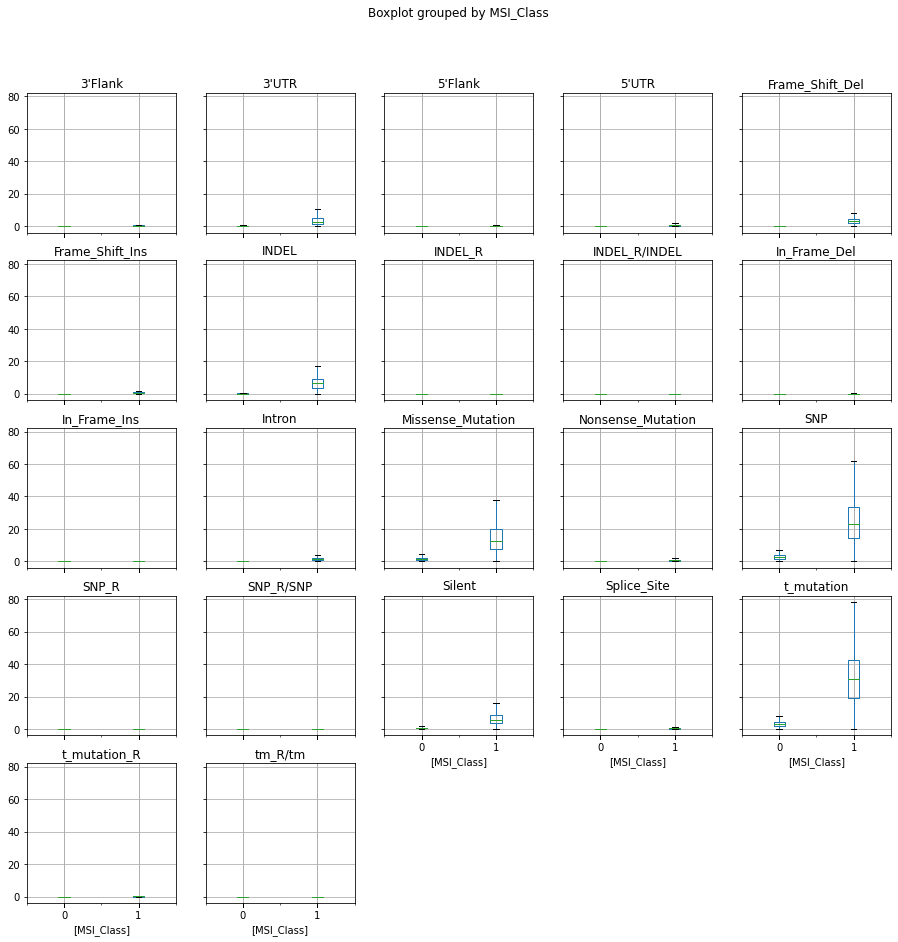

In [6]:
data.boxplot(by="MSI_Class", figsize=(15, 15), showfliers=False);

### Split training & testing

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
X = data.iloc[:, 2:24]
y = data.MSI_Class
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
list(map(np.shape, [X_train , X_test, y_train, y_test]))

[(1074, 22), (358, 22), (1074,), (358,)]

### Random Forest
To generate importance scores

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pd.DataFrame(rf_clf.feature_importances_, X.columns, ['Importance scores']).sort_values('Importance scores', ascending=False)

,Importance scores
Frame_Shift_Del,0.271594
INDEL,0.158753
Silent,0.102722
SNP,0.090862
t_mutation,0.064546
Frame_Shift_Ins,0.062788
Missense_Mutation,0.044565
5'UTR,0.038195
Nonsense_Mutation,0.032272
3'UTR,0.031837


## SVM

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

MSIpred: https://github.com/wangc29/MSIpred/blob/master/MSIpred/model_training.py

In [10]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

MSIpred_pipe = Pipeline(steps=[
            ('normalizer', StandardScaler()),
            ('classifier', SVC(C=1000, gamma=0.001))
         ])

print(cross_val_score(MSIpred_pipe, X_test, y_test))
MSIpred_pipe.fit(X_test, y_test)
print(classification_report(y_test, MSIpred_pipe.predict(X_test), digits=4))

[0.98611111 1.         0.97222222 1.         0.97183099]
              precision    recall  f1-score   support

           0     0.9890    1.0000    0.9945       270
           1     1.0000    0.9659    0.9827        88

    accuracy                         0.9916       358
   macro avg     0.9945    0.9830    0.9886       358
weighted avg     0.9917    0.9916    0.9916       358



In [11]:
from sklearn.model_selection import GridSearchCV
import numpy as np

pipe = Pipeline(steps=[
            ('standardize', StandardScaler()),
            ('SVC', SVC(cache_size=1000))
         ])

parameters = [{
               'SVC__kernel':('rbf', 'linear'),
               'SVC__C': np.logspace(-3, 4, 24)
              },
              {
               'SVC__kernel':('rbf',),
               'SVC__C': np.logspace(-3, 4, 24),
               'SVC__gamma': np.logspace(-5, 1, 7),
              }]
clf = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1, verbose=1)
clf.fit(X_train,y_train)
cv_results = pd.DataFrame(clf.cv_results_)
print(clf.best_params_)
cv_results.sort_values('rank_test_score').head(10)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 598 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1678 tasks      | elapsed:  2.9min


{'SVC__C': 1.1052951411260221, 'SVC__kernel': 'linear'}


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  3.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVC__C,param_SVC__kernel,param_SVC__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
21,0.017279,0.002074,0.001827,0.000163,1.1053,linear,NaN,"{'SVC__C': 1.1052951411260221, 'SVC__kernel': ...",0.990741,0.972222,0.981481,1.000000,0.981308,0.990654,0.990654,0.971963,0.981308,0.981308,0.984164,0.008375,1
23,0.021700,0.004401,0.001767,0.000065,2.22754,linear,NaN,"{'SVC__C': 2.227542951999559, 'SVC__kernel': '...",0.990741,0.972222,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.983238,0.006966,2
37,0.760392,0.983996,0.001947,0.000102,300.788,linear,NaN,"{'SVC__C': 300.7882518043102, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.982312,0.008755,3
35,0.305522,0.270604,0.001927,0.000142,149.25,linear,NaN,"{'SVC__C': 149.24955450518323, 'SVC__kernel': ...",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.982312,0.008755,3
47,10.628090,6.677925,0.001960,0.000131,10000,linear,NaN,"{'SVC__C': 10000.0, 'SVC__kernel': 'linear'}",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.982312,0.008755,3
26,0.015313,0.002459,0.002259,0.000168,9.04736,rbf,NaN,"{'SVC__C': 9.047357242349303, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.971963,0.981308,0.990654,0.971963,0.990654,0.990654,0.982312,0.009701,6
27,0.038820,0.006838,0.002057,0.000223,9.04736,linear,NaN,"{'SVC__C': 9.047357242349303, 'SVC__kernel': '...",0.990741,0.972222,0.981481,0.990741,0.981308,0.990654,0.971963,0.971963,0.990654,0.981308,0.982304,0.007746,7
43,5.819352,9.499426,0.001983,0.000117,2462.09,linear,NaN,"{'SVC__C': 2462.0924014946304, 'SVC__kernel': ...",0.990741,0.972222,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.971963,0.982304,0.007746,8
210,0.020068,0.003991,0.002705,0.001732,10000,rbf,0.0001,"{'SVC__C': 10000.0, 'SVC__gamma': 0.0001, 'SVC...",0.990741,0.962963,0.981481,0.981481,0.981308,0.990654,0.990654,0.971963,0.981308,0.981308,0.981386,0.008292,9
25,0.027680,0.007787,0.001913,0.000132,4.48925,linear,NaN,"{'SVC__C': 4.489251258218608, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.981308,0.990654,0.971963,0.971963,0.990654,0.981308,0.981378,0.009294,10


In [12]:
cv_linear_results = cv_results.loc[cv_results['param_SVC__kernel'] == 'linear']
cv_linear_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVC__C,param_SVC__kernel,param_SVC__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
21,0.017279,0.002074,0.001827,0.000163,1.1053,linear,NaN,"{'SVC__C': 1.1052951411260221, 'SVC__kernel': ...",0.990741,0.972222,0.981481,1.000000,0.981308,0.990654,0.990654,0.971963,0.981308,0.981308,0.984164,0.008375,1
23,0.021700,0.004401,0.001767,0.000065,2.22754,linear,NaN,"{'SVC__C': 2.227542951999559, 'SVC__kernel': '...",0.990741,0.972222,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.983238,0.006966,2
37,0.760392,0.983996,0.001947,0.000102,300.788,linear,NaN,"{'SVC__C': 300.7882518043102, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.982312,0.008755,3
35,0.305522,0.270604,0.001927,0.000142,149.25,linear,NaN,"{'SVC__C': 149.24955450518323, 'SVC__kernel': ...",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.982312,0.008755,3
47,10.628090,6.677925,0.001960,0.000131,10000,linear,NaN,"{'SVC__C': 10000.0, 'SVC__kernel': 'linear'}",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.981308,0.982312,0.008755,3
27,0.038820,0.006838,0.002057,0.000223,9.04736,linear,NaN,"{'SVC__C': 9.047357242349303, 'SVC__kernel': '...",0.990741,0.972222,0.981481,0.990741,0.981308,0.990654,0.971963,0.971963,0.990654,0.981308,0.982304,0.007746,7
43,5.819352,9.499426,0.001983,0.000117,2462.09,linear,NaN,"{'SVC__C': 2462.0924014946304, 'SVC__kernel': ...",0.990741,0.972222,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.971963,0.982304,0.007746,8
25,0.027680,0.007787,0.001913,0.000132,4.48925,linear,NaN,"{'SVC__C': 4.489251258218608, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.981308,0.990654,0.971963,0.971963,0.990654,0.981308,0.981378,0.009294,10
45,9.073721,8.826167,0.001894,0.000046,4961.95,linear,NaN,"{'SVC__C': 4961.947603002908, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.971963,0.981378,0.009294,11
41,1.728716,1.401757,0.001889,0.000043,1221.68,linear,NaN,"{'SVC__C': 1221.6773489967932, 'SVC__kernel': ...",0.990741,0.962963,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.990654,0.971963,0.981378,0.009294,11


In [13]:
cv_rbf_results = cv_results.loc[cv_results['param_SVC__kernel'] == 'rbf']
cv_rbf_results.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVC__C,param_SVC__kernel,param_SVC__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
26,0.015313,0.002459,0.002259,0.000168,9.04736,rbf,NaN,"{'SVC__C': 9.047357242349303, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.971963,0.981308,0.990654,0.971963,0.990654,0.990654,0.982312,0.009701,6
210,0.020068,0.003991,0.002705,0.001732,10000,rbf,0.0001,"{'SVC__C': 10000.0, 'SVC__gamma': 0.0001, 'SVC...",0.990741,0.962963,0.981481,0.981481,0.981308,0.990654,0.990654,0.971963,0.981308,0.981308,0.981386,0.008292,9
169,0.015701,0.002850,0.003162,0.002336,149.25,rbf,0.001,"{'SVC__C': 149.24955450518323, 'SVC__gamma': 0...",0.990741,0.972222,0.972222,0.990741,0.981308,0.990654,0.981308,0.981308,0.971963,0.981308,0.981378,0.007195,11
24,0.015157,0.002058,0.002287,0.000111,4.48925,rbf,NaN,"{'SVC__C': 4.489251258218608, 'SVC__kernel': '...",0.990741,0.962963,0.981481,0.990741,0.971963,0.981308,0.990654,0.971963,0.981308,0.990654,0.981378,0.009294,11
204,0.020801,0.003838,0.001909,0.000153,4961.95,rbf,0.001,"{'SVC__C': 4961.947603002908, 'SVC__gamma': 0....",0.990741,0.962963,0.981481,1.000000,0.971963,0.990654,0.981308,0.971963,0.981308,0.981308,0.981369,0.010183,17
156,0.014238,0.001911,0.001993,0.000111,36.7466,rbf,0.01,"{'SVC__C': 36.74661940736688, 'SVC__gamma': 0....",0.990741,0.972222,0.981481,0.990741,0.971963,0.981308,0.990654,0.962617,0.990654,0.981308,0.981369,0.009338,17
209,0.018637,0.001568,0.002013,0.000094,10000,rbf,1e-05,"{'SVC__C': 10000.0, 'SVC__gamma': 1e-05, 'SVC_...",0.981481,0.972222,0.981481,1.000000,0.981308,0.981308,0.990654,0.971963,0.971963,0.981308,0.981369,0.008331,17
189,0.016497,0.002734,0.001909,0.000066,1221.68,rbf,0.0001,"{'SVC__C': 1221.6773489967932, 'SVC__gamma': 0...",0.981481,0.981481,0.981481,0.990741,0.981308,0.981308,0.990654,0.971963,0.971963,0.981308,0.981369,0.005925,17
196,0.019378,0.003425,0.001883,0.000146,2462.09,rbf,0.0001,"{'SVC__C': 2462.0924014946304, 'SVC__gamma': 0...",0.990741,0.981481,0.981481,0.990741,0.981308,0.971963,0.990654,0.971963,0.971963,0.981308,0.981360,0.007262,23
34,0.017888,0.003249,0.002189,0.000071,149.25,rbf,NaN,"{'SVC__C': 149.24955450518323, 'SVC__kernel': ...",0.990741,0.962963,0.981481,0.981481,0.971963,0.971963,0.990654,0.971963,0.990654,0.990654,0.980452,0.009707,24


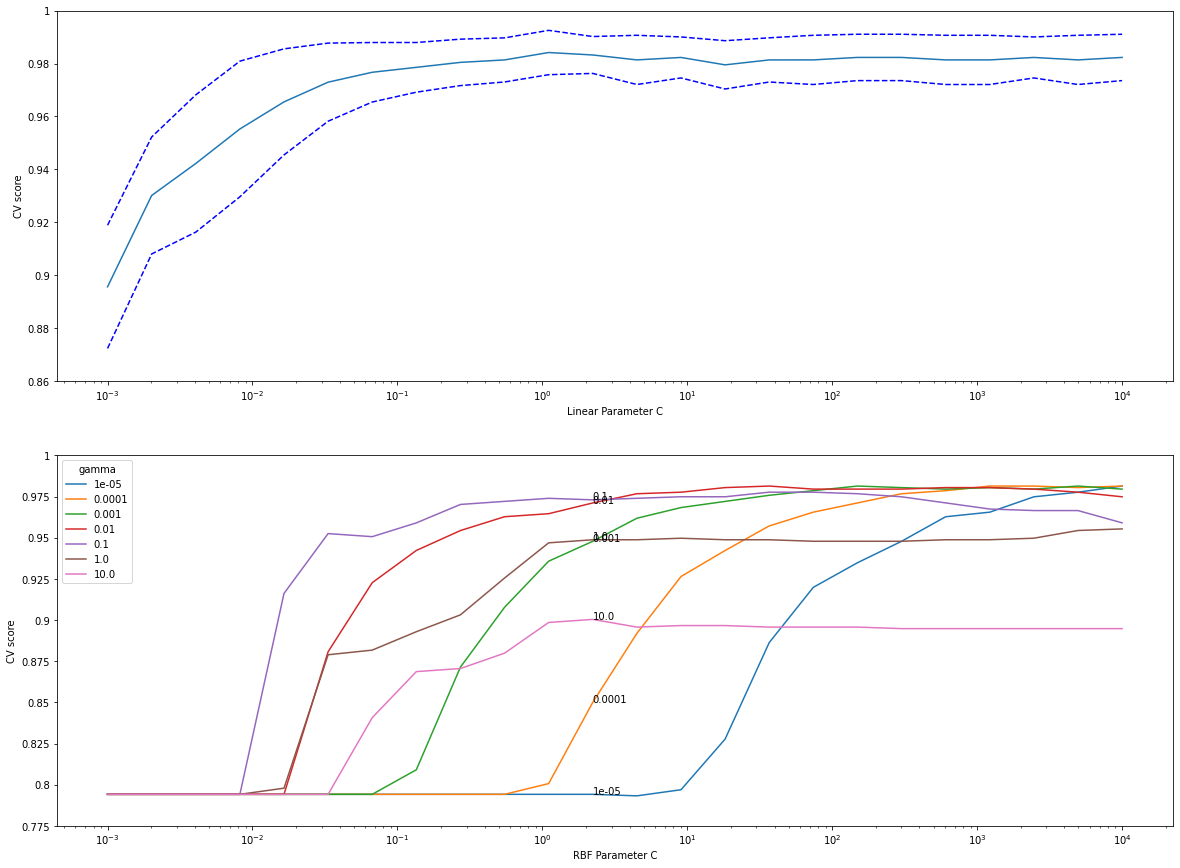

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

plt.subplot(211)
Cs = cv_linear_results['param_SVC__C']
scores = cv_linear_results['mean_test_score']
scores_std = cv_linear_results['std_test_score']
plt.semilogx(Cs, scores)
plt.semilogx(Cs, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(Cs, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Linear Parameter C')

plt.subplot(212)
for gamma, cv_rbf_results_group in cv_rbf_results.groupby('param_SVC__gamma'):
    Cs = cv_rbf_results_group['param_SVC__C']
    scores = cv_rbf_results_group['mean_test_score']
    plt.semilogx(Cs, scores, label=gamma)
    plt.text(Cs.iloc[11], scores.iloc[11], gamma)
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('RBF Parameter C')
plt.legend(title='gamma')

plt.show()

In [16]:
pipe.set_params(SVC__kernel='linear')
parameters = {'SVC__C': np.linspace(1e0, 1e2, 500)}
clf = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
clf.best_estimator_.get_params()

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 2312 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3012 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3912 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  5.0min finished


{'SVC': SVC(C=1.1983967935871744, break_ties=False, cache_size=1000, class_weight=None,
     coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
     kernel='linear', max_iter=-1, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False),
 'SVC__C': 1.1983967935871744,
 'SVC__break_ties': False,
 'SVC__cache_size': 1000,
 'SVC__class_weight': None,
 'SVC__coef0': 0.0,
 'SVC__decision_function_shape': 'ovr',
 'SVC__degree': 3,
 'SVC__gamma': 'scale',
 'SVC__kernel': 'linear',
 'SVC__max_iter': -1,
 'SVC__probability': False,
 'SVC__random_state': None,
 'SVC__shrinking': True,
 'SVC__tol': 0.001,
 'SVC__verbose': False,
 'memory': None,
 'standardize': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'steps': [('standardize',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('SVC',
   SVC(C=1.1983967935871744, break_ties=False, c

From article:
> MSIpred finally achieved a sensitivity (recall) of 0.936, specificity of 0.996, precision of 0.986, G mean of 0.966, F1 score of 0.961, and overall accuracy of 0.983. ROC curve (Fig. 2a) of MSIpred achieved area under curve of 0.969.

              precision    recall  f1-score   support

           0     0.9890    1.0000    0.9945       270
           1     1.0000    0.9659    0.9827        88

    accuracy                         0.9916       358
   macro avg     0.9945    0.9830    0.9886       358
weighted avg     0.9917    0.9916    0.9916       358



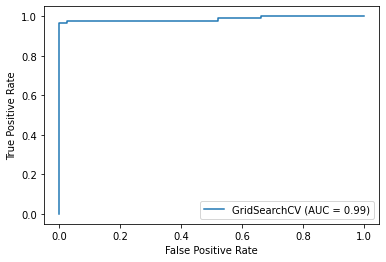

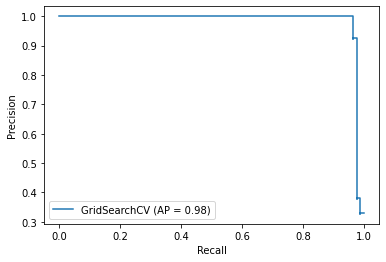

In [17]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
print(classification_report(y_test, clf.predict(X_test), digits=4))
plot_roc_curve(clf, X_test, y_test);
plot_precision_recall_curve(clf, X_test, y_test);

## Non-TCGA

In [18]:
url_non_tcga = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-35682-z/MediaObjects/41598_2018_35682_MOESM3_ESM.csv"
data_non_tcga = pd.read_csv(url_non_tcga)
data_non_tcga.describe(include="all")

,Tumor,SNP,INDEL,SNP_R,INDEL_R,t_mutation,t_mutation_R,SNP_R/SNP,INDEL_R/INDEL,tm_R/tm,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Silent,Splice_Site,3'UTR,3'Flank,5'UTR,5'Flank,Intron,MSI_STATUS,MSIpred_Predicted_MSI_status,MSIseq_Predicted_MSI_status
count,390,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,352.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390,390,390
unique,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2
top,coadread_dfci_2016_1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSS,MSS,MSS
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300,317,328
mean,NaN,4.994852,0.702377,0.003100,0.000230,5.697228,0.003330,0.000756,0.001497,0.000767,0.445426,0.119578,0.031375,0.001542,4.758960,0.010039,0.087511,0.007597,0.014480,0.005490,0.007512,0.004582,0.161167,NaN,NaN,NaN
std,NaN,6.979976,1.851129,0.007344,0.002128,8.163537,0.007849,0.002459,0.026660,0.002519,0.953848,0.234350,0.061840,0.005870,6.670190,0.056429,0.530570,0.053609,0.056609,0.014150,0.025408,0.011382,1.081221,NaN,NaN,NaN
min,NaN,0.105263,0.000000,0.000000,0.000000,0.131579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,1.481343,0.014925,0.000000,0.000000,1.537313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.447761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
50%,NaN,2.261194,0.044776,0.000000,0.000000,2.314611,0.000000,0.000000,0.000000,0.000000,0.026316,0.014925,0.000000,0.000000,2.141791,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,NaN,NaN,NaN
75%,NaN,4.821877,0.184211,0.000000,0.000000,5.545169,0.000000,0.000000,0.000000,0.000000,0.074627,0.059701,0.014925,0.000000,4.548507,0.000000,0.029851,0.000000,0.014925,0.000000,0.014925,0.000000,0.059701,NaN,NaN,NaN


In [0]:
data_non_tcga['MSI_Class'] = data_non_tcga['MSI_STATUS'].map({'MSS': 0, 'MSI-H': 1})
X_non_tcga = data_non_tcga.iloc[:, 1:23].fillna(0)
y_non_tcga = data_non_tcga.MSI_Class

From article:
> With this non-TCGA testing set, MSIpred achieved a sensitivity (recall) of 0.778, specificity of 0.990, precision of 0.959, G mean of 0.877, F1 score of 0.859, and overall accuracy of 0.941.

              precision    recall  f1-score   support

           0     0.9369    0.9900    0.9627       300
           1     0.9589    0.7778    0.8589        90

    accuracy                         0.9410       390
   macro avg     0.9479    0.8839    0.9108       390
weighted avg     0.9420    0.9410    0.9388       390



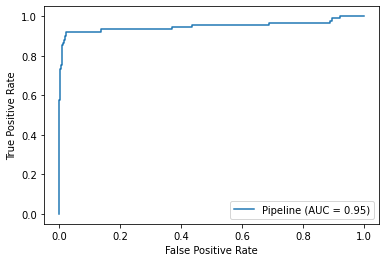

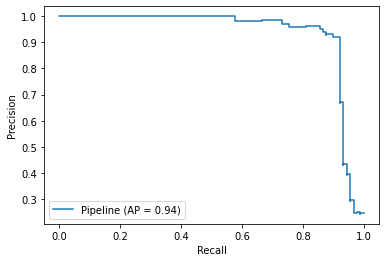

In [20]:
print(classification_report(y_non_tcga, MSIpred_pipe.predict(X_non_tcga), digits=4))
plot_roc_curve(MSIpred_pipe, X_non_tcga, y_non_tcga);
plot_precision_recall_curve(MSIpred_pipe, X_non_tcga, y_non_tcga);

              precision    recall  f1-score   support

           0     0.9340    0.9900    0.9612       300
           1     0.9583    0.7667    0.8519        90

    accuracy                         0.9385       390
   macro avg     0.9461    0.8783    0.9065       390
weighted avg     0.9396    0.9385    0.9359       390



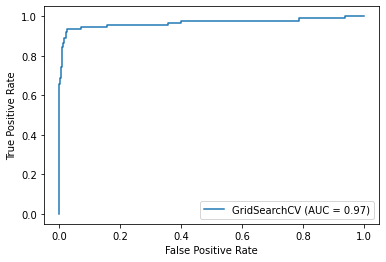

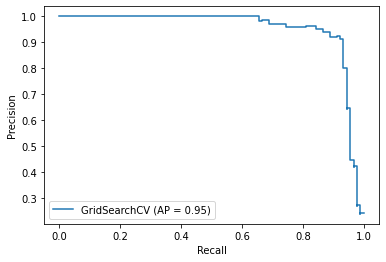

In [21]:
print(classification_report(y_non_tcga, clf.predict(X_non_tcga), digits=4))
plot_roc_curve(clf, X_non_tcga, y_non_tcga);
plot_precision_recall_curve(clf, X_non_tcga, y_non_tcga);